In [1]:
#TODO remove
#interesting code:
#: https://github.com/reeanne/FinalProject/blob/cef6b45060ad9646f2be4de93c226aebeadec41b/essentia-master/src/examples/python/streaming_extractor/tonaldescriptors.py
#https://github.com/LqNoob/Essentia/blob/7a70a25dd6668855b3677bd0cae0df190e319cbf/test/src/unittest/tonal/test_chordsdetection_streaming.py
#∫imple one https://github.com/mariogearth/ChordsDetectionPython/blob/b69e813bef92a361e7cad0a58bbd0f049b252914/old%20stuff/chords_test3.py

In [2]:
#Look at TODOs!!

In [3]:
import sys, os
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.streaming import *

In [7]:
'''
UTILS 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def tuning(infile):
    hopSize = 2048
    frameSize = 8192
    loader = MonoLoader(filename=infile)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = TuningFrequency()
    # use pool to store data
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')
    # network is ready, run it
    print ('Processing audio file...', infile)
    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

In [5]:
'''
Compute Chords by Frames in Essentia 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def computeChordsByFrames(filename, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitMax')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

Processing audio file... ./test-audio/Disc 1 - 01 - Maple Leaf Rag.flac
song tuning:  442.284


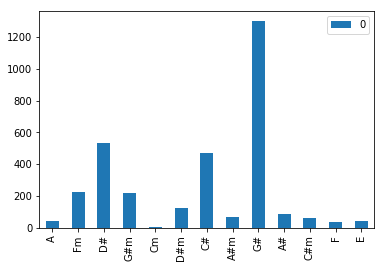

In [6]:
#TEST
testAudio = './test-audio/Disc 1 - 01 - Maple Leaf Rag.flac'

#get tuning --> do we need this anyway?
song_tuning = tuning(testAudio)
print('song tuning: ',song_tuning)

(test, test2, chords, test4) = computeChordsByFrames(testAudio, tuningFrequency=song_tuning)

#chord histogram
chord_counts = Counter(chords)
df = pd.DataFrame.from_dict(chord_counts, orient='index')
df.plot(kind='bar')


In [87]:
'''
Compute Chords by Beats in Essentia

  https://github.com/seffka/ACE2017/blob/467068d9667de43de8b8b8396e620d9e62a0d85c/essentia_chords_beats.py

'''

import sys
import os
from essentia.streaming import *
from essentia.standard import YamlOutput
from essentia.standard import BeatTrackerMultiFeature
from essentia.standard import ChordsDetectionBeats
import numpy as np


#def computeChordsByFrames(filename, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

def chordBeats(filename, hopSize=4096, frameSize=8192, tuningFrequency=440.0):
    
    # use pool to store data
    pool = essentia.Pool()
    # initialize algorithms we will use
    loader = MonoLoader(filename=filename)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = HPCP(size=12,
                referenceFrequency = tuningFrequency,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)

    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    ## network is ready, run it
    essentia.run(loader)
    ## don't forget, we can actually instantiate and call an algorithm on the same line!

    print('Loading audio file...', filename)
    audio = essentia.standard.MonoLoader(filename = filename)()
    bt = BeatTrackerMultiFeature()
    beats, confidence = bt(audio)
    
    #ticks = beats[::4] # TODO: we now take one of 4 each beats, not good
    print("number of beats", len(beats))

    chordBeats = ChordsDetectionBeats(hopSize=hopSize)
    chords, strengths = chordBeats(pool['chroma.hpcp'], beats)
    #print('size: ', len(pool['chroma.hpcp']))
    return chords, strengths, beats
    
    
    
    
    
    
'''    
    #name, ext = os.path.splitext(outfile)
    #YamlOutput(filename=name+'.chroma.json')(pool)
    segments = essentia_chord_utils.toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
            
    

            

try:
    filename = sys.argv[1]
    outfile = sys.argv[2]
except:
    print "usage:", sys.argv[0], "<input directory (with audio)> <output lab directory>"
    sys.exit()

'''
    


#essentia_chord_utils.processFiles(infile, outfile, chordBeats)
#chordBeats("test.lab")

'    \n    #name, ext = os.path.splitext(outfile)\n    #YamlOutput(filename=name+\'.chroma.json\')(pool)\n    segments = essentia_chord_utils.toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)\n    with open(outfile, \'w\') as content_file:\n        for s in segments:\n            content_file.write(str(s) + \'\n\')\n            \n    \n\n            \n\ntry:\n    filename = sys.argv[1]\n    outfile = sys.argv[2]\nexcept:\n    print "usage:", sys.argv[0], "<input directory (with audio)> <output lab directory>"\n    sys.exit()\n\n'

Processing audio file... ./test-audio/Disc 1 - 01 - Maple Leaf Rag.flac
song tuning:  442.284
Loading audio file... ./test-audio/Disc 1 - 01 - Maple Leaf Rag.flac
number of beats 300
chords obtained:  299


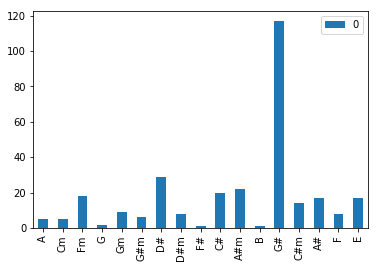

In [88]:
#TEST chordBeats
testAudio = './test-audio/Disc 1 - 01 - Maple Leaf Rag.flac'

#get tuning --> do we need this anyway?
song_tuning = tuning(testAudio)
print('song tuning: ',song_tuning)

(chords, strengths, beats) = chordBeats(testAudio, tuningFrequency=song_tuning)

print("chords obtained: " , len(chords))

#chord histogram
chord_counts = Counter(chords)
df = pd.DataFrame.from_dict(chord_counts, orient='index')
df.plot(kind='bar')




In [43]:
len(beats[::4])

75

In [ ]:
#mir_eval interesting funtions

mir_eval.chord.validate_chord_label
#If no chord is present at a given point in time, it should have the label ‘N’, which is defined in the variable 
mir_eval.chord.NO_CHORD

When converting the chord string into its constituent parts,

Pitch class counting starts at C, e.g. C:0, D:2, E:4, F:5, etc.
Scale degree is represented as a string of the diatonic interval, relative to the root note, e.g. ‘b6’, ‘#5’, or ‘7’
Bass intervals are represented as strings
Chord bitmaps are positional binary vectors indicating active pitch classes and may be absolute or relative depending on context in the code.




In [97]:
import mir_eval
mir_eval

<module 'mir_eval' from '/essentia/src/mir-eval/mir_eval/__init__.py'>

In [98]:
QUALITIES = {
    #           1     2     3     4  5     6     7
    'maj':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    'min':     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    'aug':     [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    'dim':     [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    'sus4':    [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    'sus2':    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '7':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min7':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    'minmaj7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    'maj6':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
    'min6':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
    'dim7':    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    'hdim7':   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    'maj9':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min9':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '9':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'min11':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '11':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#11':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj13':   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min13':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '13':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b13':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '1':       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    '5':       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '':        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}